### Distance distribution from variant to tss

pcQTL vs eQTL distance to the nearest gene in the cluster
* break out pc1 signals specifically 


the idea is that the pcqtls are maybe picking up on more distant signals or regulatory elements


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks
from scipy.stats import ttest_ind


# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000
mpl.rcParams['figure.dpi']= 100

prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


In [4]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)[1:]

In [5]:
susie_annotated = load_across_tissues(config, load_susie_annotated, tissue_ids = tissue_ids)
susie_annotated['position'] = susie_annotated['variant_id'].str.split('_').str[1].astype(int)

# TSS distance

In [12]:
# already done as part of the susie annotations

# # load in the gene information (start and strand are what I need)
# gid_gencode, full_gencode = load_gencode()

# # distance to whichever gene in the cluster is closest
# def get_tss(row, gid_gencode):
#     cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
#     starts = cluster_gene_df['tss_start'].values
#     distances = row['position'] - starts
#     # return smallest absolute value distance
#     idx = np.argmin(abs(distances))
#     # make relative to gene orientation
#     if cluster_gene_df.iloc[idx]['strand'] == '-':
#         return -distances[idx]
#     else:
#         return distances[idx]
    
# # for just the egenes, get the egene start that actually matched the gene of interest
# def get_egene_distance(row, gid_gencode):
#     assert row['type'] =='eqtl'
#     egene = row['cs_id'].split('_e_')[1]
#     gene_df = gid_gencode.loc[egene]
#     #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
#     # make relative to gene orientation
#     if gene_df['strand'] == '-':
#         return -(row['position']-gene_df.tss_start)
#     else:
#         return row['position']-gene_df.tss_start

# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
#susie_annotated['cluster_min_distance'] = susie_annotated.progress_apply(get_tss, axis=1, args=(gid_gencode,))

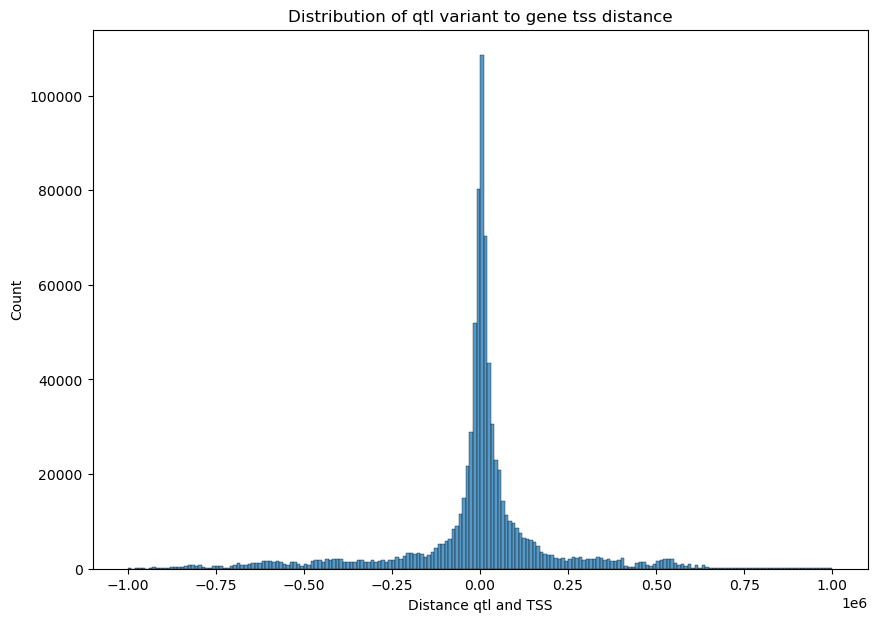

In [13]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))
# you can ocasionally get variants further than this due to large cluster sizes
# clipped for clarity 
sns.histplot(susie_annotated['cluster_min_distance'].clip(-1000000, 1000000), bins=200, ax=ax)
ax.set_xlabel('Distance qtl and TSS')
ax.set_title('Distribution of qtl variant to gene tss distance')
plt.show()

In [16]:
# pip weighted distance
susie_annotated['distance_pip'] = susie_annotated['pip'] * susie_annotated['cluster_min_distance'].abs()
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'distance_pip':'sum', 'lead_variant_id':'first', 'type':'first'}).reset_index()
cs_grouped['clip_distance'] = cs_grouped['distance_pip'].clip(-1000000, 1000000).abs()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

In [ ]:
# add in underlying signal ids
underlying_signals = load_across_tissues(config, load_signal_groups, tissue_ids = tissue_ids)

underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals.explode('cs_id')

cs_grouped = pd.merge(cs_grouped, underlying_signals.explode('cs_id'), how='left', on=['tissue_id', 'cs_id'])

(0.0, 100000.0)

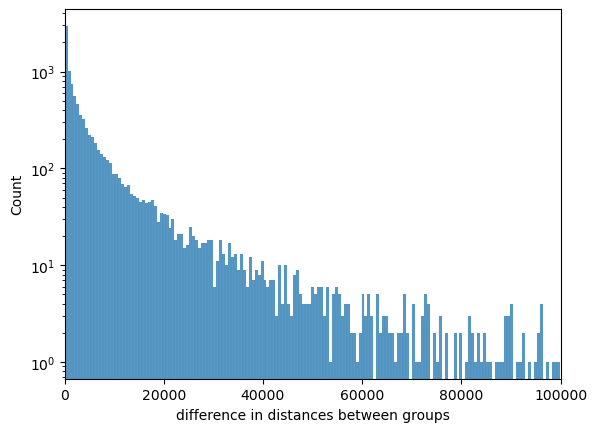

In [ ]:
# the different distances in different credible sets shouldn't be too different 
signal_grouped = cs_grouped.groupby(['signal_id', 'tissue_id']).agg({'clip_distance':['min', 'max']}).reset_index()
multi_signal_grouped = signal_grouped[signal_grouped['signal_id'].str.split('-').apply(len)>1]

ax = sns.histplot(multi_signal_grouped[('clip_distance', 'max')] - multi_signal_grouped[('clip_distance', 'min')])
ax.set_xlabel('difference in distances between groups')
ax.set_yscale('log')
ax.set_xlim(0, 100000)


In [69]:
signal_grouped = cs_grouped.groupby(['signal_id', 'tissue_id']).agg({'clip_distance':'mean','num_e_coloc':'first', 'num_pc_coloc':'first'}).reset_index()
signal_grouped['exclusive_label'] = np.where((signal_grouped['num_e_coloc'] > 0), 
                                               np.where((signal_grouped['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

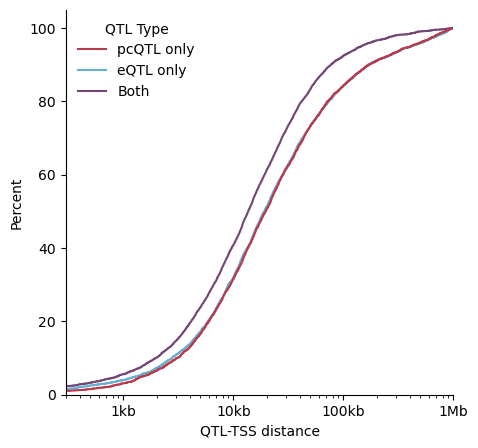

Ttest_indResult(statistic=-0.32745175881006433, pvalue=0.7433333666256515)


In [70]:
fig, ax = plt.subplots(figsize=(5,5))
sns.ecdfplot(signal_grouped, x='clip_distance', hue='exclusive_label',  stat="percent", ax=ax, log_scale=True,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel('QTL-TSS distance')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

xlim=100000
ax.set_xlim(300, xlim)

ax.set_xticks([1000, 10000, 100000, 1000000])
ax.set_xticklabels(['1kb', '10kb', '100kb', '1Mb'])

plt.show()

print(ttest_ind(signal_grouped[signal_grouped['exclusive_label']=='pcqtl_only']['clip_distance'], signal_grouped[signal_grouped['exclusive_label']=='eqtl_only']['clip_distance']))

In [71]:
signal_grouped.loc[((signal_grouped['signal_id'].astype(str).str.contains('pc1'))&(signal_grouped['exclusive_label']=='pcqtl_only')), 'exclusive_label'] = 'first_pcqtl_only'

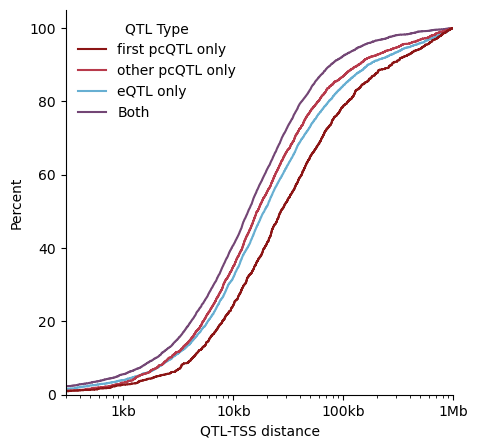

Ttest_indResult(statistic=4.43055160201125, pvalue=9.551839702412992e-06)


In [73]:
fig, ax = plt.subplots(figsize=(5,5))
sns.ecdfplot(signal_grouped, x='clip_distance', hue='exclusive_label',  stat="percent", ax=ax, log_scale=True,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675', 'first_pcqtl_only':'#8C1515'}, hue_order=['first_pcqtl_only','pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel('QTL-TSS distance')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['first pcQTL only', 'other pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

xlim=100000
ax.set_xlim(300, xlim)

ax.set_xticks([1000, 10000, 100000, 1000000])
ax.set_xticklabels(['1kb', '10kb', '100kb', '1Mb'])

plt.show()

print(ttest_ind(signal_grouped[signal_grouped['exclusive_label']=='first_pcqtl_only']['clip_distance'], signal_grouped[signal_grouped['exclusive_label']=='eqtl_only']['clip_distance']))